# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

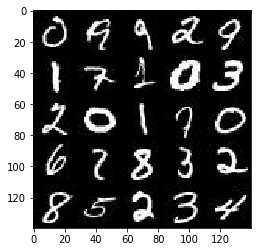

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

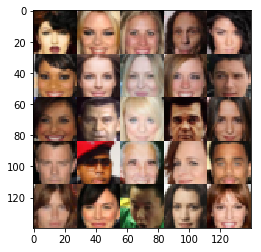

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,[None,image_width,image_height,image_channels],name="input_real")
    z = tf.placeholder(tf.float32,[None,z_dim],name='z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False,alpha = 0.05):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        #Conv layer1 - 14x14x32
        layer1 = tf.layers.conv2d(images,32,(5,5),strides=(2,2),padding='same')
        layer1 = tf.maximum(layer1*alpha,layer1)
        
        #Conv layer2 - 7x7x64
        layer2 = tf.layers.conv2d(layer1,64,(5,5),strides=(1,1),padding='same')
        layer2 = tf.layers.batch_normalization(layer2,training=True)
        layer2 = tf.maximum(layer2*alpha,layer2)
        #layer2 = layer1
        
        layer3 = tf.layers.conv2d(layer2,128,(5,5),strides=(2,2),padding='same')
        layer3 = tf.layers.batch_normalization(layer3,training=True)
        layer3 = tf.maximum(layer3*alpha,layer3)
        
        #fully connected
        #flatten
        layer4 = tf.contrib.layers.flatten(layer3)
        logits = tf.layers.dense(layer4, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True,alpha = 0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #reuse variable for inference
    reuse = False if is_train else True
    with tf.variable_scope('generator',reuse=reuse):
        #fully connected 7*7*512
        layer1 = tf.layers.dense(z,7*7*256)
        
        layer1 = tf.reshape(layer1, [-1,7,7,256])
        layer1 = tf.layers.batch_normalization(layer1,training=is_train)
        layer1 = tf.maximum(layer1*alpha,layer1)
        
        #layer2 conv2d transpose 14x14x256
        layer2 = tf.layers.conv2d_transpose(layer1,128,(5,5),strides=(2,2),padding='same')
        layer2 = tf.layers.batch_normalization(layer2,training=is_train)
        layer2 = tf.maximum(alpha*layer2,layer2)
  
        #layer3 conv2d transpose 28x28x128
        layer3 = tf.layers.conv2d_transpose(layer2,64,(5,5),strides=(2,2),padding='same')
        layer3 = tf.layers.batch_normalization(layer3,training=is_train)
        layer3 = tf.maximum(alpha*layer3,layer3)
        #layer3 = layer2
        #Output layer - layer4 conv2d transpose 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(layer3,out_channel_dim,(5,5),strides=(1,1),padding='same')

        
    return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    d_real_out, d_real_logits = discriminator(input_real,reuse=False)
    g_out = generator(input_z, out_channel_dim, is_train=True)
    d_fake_out, d_fake_logits = discriminator(g_out,reuse=True)
    
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                             logits=d_real_logits, labels=tf.ones_like(d_real_logits) * 0.9))
    
    d_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                            logits=d_fake_logits, labels=tf.zeros_like(d_fake_out)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                   logits=d_fake_logits, labels=tf.ones_like(d_fake_out)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    num_batches = data_shape[0]//batch_size
    num_images = 16
    show_steps = 500
    loss_steps = 150
    #print("num_batches",num_batches)
    input_real, input_z, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            count = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                count += 1
                z = np.random.uniform(-1,1,(batch_size,z_dim))
                sess.run(d_opt,feed_dict={input_real:batch_images,input_z:z,lr:learning_rate})
                sess.run(g_opt,feed_dict={input_real:batch_images,input_z:z,lr:learning_rate})
                sess.run(g_opt,feed_dict={input_real:batch_images,input_z:z,lr:learning_rate})
                #sess.run(g_opt,feed_dict={input_real:batch_images,input_z:z,lr:learning_rate})
                
                if count % show_steps == 0:
                    show_generator_output(sess, num_images, input_z, data_shape[-1], data_image_mode)
                if count % loss_steps == 0:
                    train_g_loss = sess.run(g_loss,feed_dict={input_real:batch_images,input_z:z})
                    train_d_loss = sess.run(d_loss,feed_dict={input_real:batch_images,input_z:z})
                    print("Epoch_i {}   batch count {}/{}...".format(epoch_i,count,num_batches),
                          "Discriminator Loss: {:.4f}...".format(train_d_loss),
                          "Generator Loss: {:.4f}".format(train_g_loss))
            show_generator_output(sess, num_images, input_z, data_shape[-1], data_image_mode)
            train_g_loss = sess.run(g_loss,feed_dict={input_real:batch_images,input_z:z})
            train_d_loss = sess.run(d_loss,feed_dict={input_real:batch_images,input_z:z})
            print("Epoch_i {}   batch count {}/{}...".format(epoch_i,count,num_batches),
                  "Discriminator Loss: {:.4f}...".format(train_d_loss),
                  "Generator Loss: {:.4f}".format(train_g_loss))
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch_i 0   batch count 150/1875... Discriminator Loss: 0.5734... Generator Loss: 1.8918
Epoch_i 0   batch count 300/1875... Discriminator Loss: 1.1933... Generator Loss: 1.3024
Epoch_i 0   batch count 450/1875... Discriminator Loss: 0.8261... Generator Loss: 2.2297


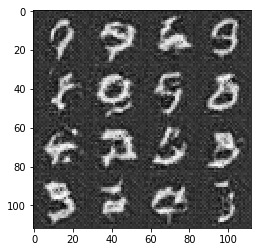

Epoch_i 0   batch count 600/1875... Discriminator Loss: 1.7839... Generator Loss: 0.3472
Epoch_i 0   batch count 750/1875... Discriminator Loss: 1.4034... Generator Loss: 0.7241
Epoch_i 0   batch count 900/1875... Discriminator Loss: 1.7100... Generator Loss: 0.3523


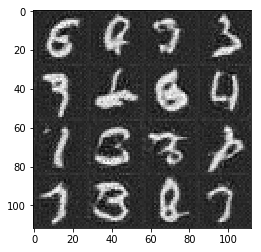

Epoch_i 0   batch count 1050/1875... Discriminator Loss: 1.1343... Generator Loss: 0.9227
Epoch_i 0   batch count 1200/1875... Discriminator Loss: 1.2266... Generator Loss: 0.9307
Epoch_i 0   batch count 1350/1875... Discriminator Loss: 2.1102... Generator Loss: 0.2476


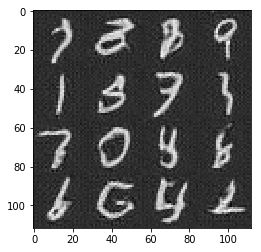

Epoch_i 0   batch count 1500/1875... Discriminator Loss: 1.1366... Generator Loss: 0.8148
Epoch_i 0   batch count 1650/1875... Discriminator Loss: 0.9915... Generator Loss: 0.9725
Epoch_i 0   batch count 1800/1875... Discriminator Loss: 2.0696... Generator Loss: 0.2859


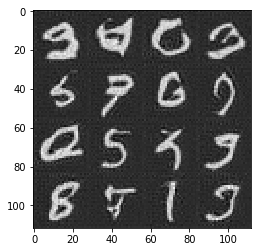

Epoch_i 0   batch count 1875/1875... Discriminator Loss: 1.0157... Generator Loss: 1.3491
Epoch_i 1   batch count 150/1875... Discriminator Loss: 2.1846... Generator Loss: 0.2291
Epoch_i 1   batch count 300/1875... Discriminator Loss: 0.8441... Generator Loss: 1.5791
Epoch_i 1   batch count 450/1875... Discriminator Loss: 2.9194... Generator Loss: 0.1130


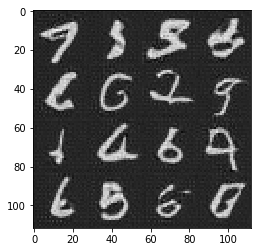

Epoch_i 1   batch count 600/1875... Discriminator Loss: 2.3180... Generator Loss: 0.1778
Epoch_i 1   batch count 750/1875... Discriminator Loss: 1.1348... Generator Loss: 1.4188
Epoch_i 1   batch count 900/1875... Discriminator Loss: 1.7239... Generator Loss: 0.3889


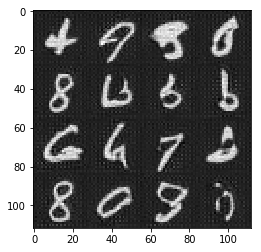

Epoch_i 1   batch count 1050/1875... Discriminator Loss: 1.9671... Generator Loss: 0.3198
Epoch_i 1   batch count 1200/1875... Discriminator Loss: 0.8618... Generator Loss: 1.1208
Epoch_i 1   batch count 1350/1875... Discriminator Loss: 1.7591... Generator Loss: 0.4073


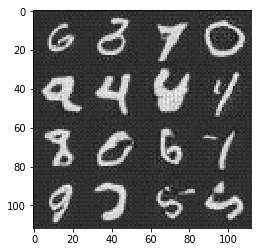

Epoch_i 1   batch count 1500/1875... Discriminator Loss: 1.2801... Generator Loss: 0.6885
Epoch_i 1   batch count 1650/1875... Discriminator Loss: 0.7200... Generator Loss: 2.2401
Epoch_i 1   batch count 1800/1875... Discriminator Loss: 2.2063... Generator Loss: 0.2710


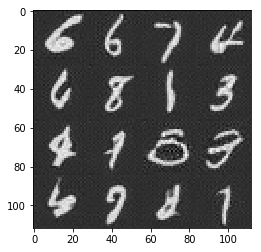

Epoch_i 1   batch count 1875/1875... Discriminator Loss: 1.5214... Generator Loss: 0.4485


In [20]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
tf.reset_default_graph()
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch_i 0   batch count 150/12662... Discriminator Loss: 1.3623... Generator Loss: 0.5881
Epoch_i 0   batch count 300/12662... Discriminator Loss: 1.7549... Generator Loss: 0.6407
Epoch_i 0   batch count 450/12662... Discriminator Loss: 1.9668... Generator Loss: 0.5378


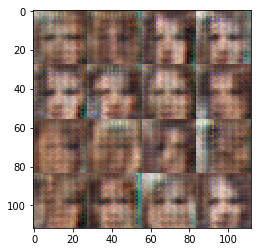

Epoch_i 0   batch count 600/12662... Discriminator Loss: 1.7986... Generator Loss: 0.4160
Epoch_i 0   batch count 750/12662... Discriminator Loss: 1.4860... Generator Loss: 0.5560
Epoch_i 0   batch count 900/12662... Discriminator Loss: 1.5097... Generator Loss: 0.7499


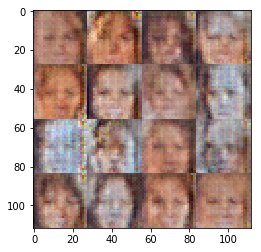

Epoch_i 0   batch count 1050/12662... Discriminator Loss: 1.3346... Generator Loss: 0.8742
Epoch_i 0   batch count 1200/12662... Discriminator Loss: 1.5155... Generator Loss: 0.8288
Epoch_i 0   batch count 1350/12662... Discriminator Loss: 1.4345... Generator Loss: 0.7305


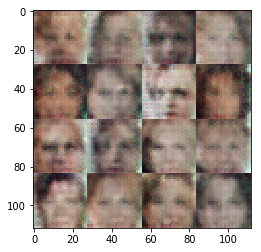

Epoch_i 0   batch count 1500/12662... Discriminator Loss: 1.6022... Generator Loss: 0.6158
Epoch_i 0   batch count 1650/12662... Discriminator Loss: 1.5095... Generator Loss: 0.6899
Epoch_i 0   batch count 1800/12662... Discriminator Loss: 1.4629... Generator Loss: 0.7892
Epoch_i 0   batch count 1950/12662... Discriminator Loss: 1.3902... Generator Loss: 0.7978


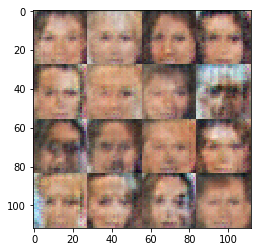

Epoch_i 0   batch count 2100/12662... Discriminator Loss: 1.4079... Generator Loss: 0.7317
Epoch_i 0   batch count 2250/12662... Discriminator Loss: 1.3615... Generator Loss: 0.7006
Epoch_i 0   batch count 2400/12662... Discriminator Loss: 1.2608... Generator Loss: 0.8956


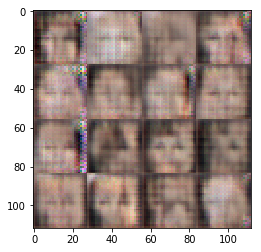

Epoch_i 0   batch count 2550/12662... Discriminator Loss: 0.8534... Generator Loss: 1.1581
Epoch_i 0   batch count 2700/12662... Discriminator Loss: 1.5813... Generator Loss: 0.5629
Epoch_i 0   batch count 2850/12662... Discriminator Loss: 1.3607... Generator Loss: 0.7405


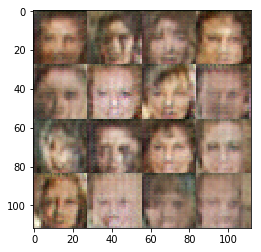

Epoch_i 0   batch count 3000/12662... Discriminator Loss: 1.4589... Generator Loss: 0.5902
Epoch_i 0   batch count 3150/12662... Discriminator Loss: 1.4249... Generator Loss: 0.7856
Epoch_i 0   batch count 3300/12662... Discriminator Loss: 1.4268... Generator Loss: 0.7313
Epoch_i 0   batch count 3450/12662... Discriminator Loss: 1.4355... Generator Loss: 0.6890


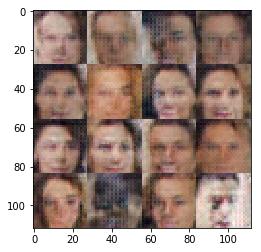

Epoch_i 0   batch count 3600/12662... Discriminator Loss: 1.4105... Generator Loss: 0.7571
Epoch_i 0   batch count 3750/12662... Discriminator Loss: 1.4452... Generator Loss: 0.7246
Epoch_i 0   batch count 3900/12662... Discriminator Loss: 1.3430... Generator Loss: 0.7769


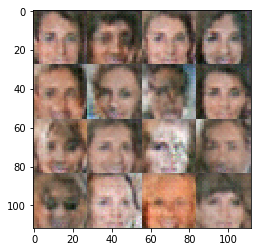

Epoch_i 0   batch count 4050/12662... Discriminator Loss: 1.4781... Generator Loss: 0.7463
Epoch_i 0   batch count 4200/12662... Discriminator Loss: 1.5153... Generator Loss: 0.6641
Epoch_i 0   batch count 4350/12662... Discriminator Loss: 1.3801... Generator Loss: 0.7937


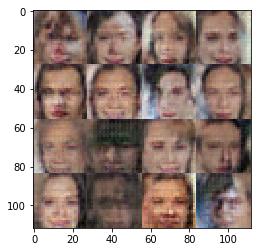

Epoch_i 0   batch count 4500/12662... Discriminator Loss: 1.4416... Generator Loss: 0.7119
Epoch_i 0   batch count 4650/12662... Discriminator Loss: 1.4249... Generator Loss: 0.8376
Epoch_i 0   batch count 4800/12662... Discriminator Loss: 1.4252... Generator Loss: 0.6961
Epoch_i 0   batch count 4950/12662... Discriminator Loss: 1.4343... Generator Loss: 0.6759


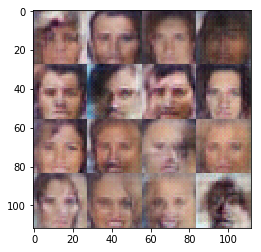

Epoch_i 0   batch count 5100/12662... Discriminator Loss: 1.4885... Generator Loss: 0.7068
Epoch_i 0   batch count 5250/12662... Discriminator Loss: 1.4068... Generator Loss: 0.7013
Epoch_i 0   batch count 5400/12662... Discriminator Loss: 1.3634... Generator Loss: 0.7469


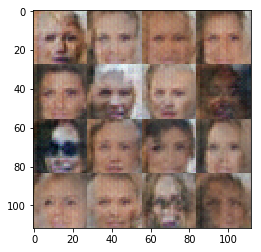

Epoch_i 0   batch count 5550/12662... Discriminator Loss: 1.4292... Generator Loss: 0.6682
Epoch_i 0   batch count 5700/12662... Discriminator Loss: 1.5160... Generator Loss: 0.6708
Epoch_i 0   batch count 5850/12662... Discriminator Loss: 1.3825... Generator Loss: 0.7775


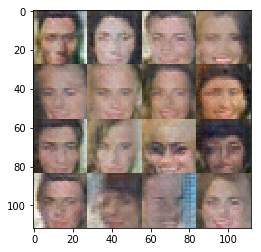

Epoch_i 0   batch count 6000/12662... Discriminator Loss: 1.3989... Generator Loss: 0.6871
Epoch_i 0   batch count 6150/12662... Discriminator Loss: 1.5124... Generator Loss: 0.6582
Epoch_i 0   batch count 6300/12662... Discriminator Loss: 1.4049... Generator Loss: 0.7724
Epoch_i 0   batch count 6450/12662... Discriminator Loss: 1.4319... Generator Loss: 0.7156


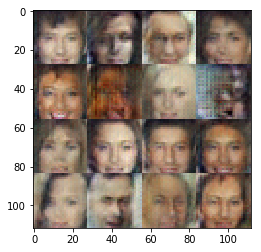

Epoch_i 0   batch count 6600/12662... Discriminator Loss: 1.4524... Generator Loss: 0.6628
Epoch_i 0   batch count 6750/12662... Discriminator Loss: 1.4491... Generator Loss: 0.6582
Epoch_i 0   batch count 6900/12662... Discriminator Loss: 1.4707... Generator Loss: 0.6388


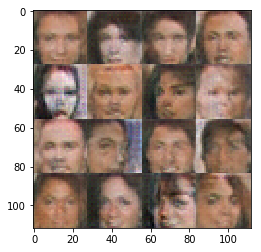

Epoch_i 0   batch count 7050/12662... Discriminator Loss: 1.4101... Generator Loss: 0.7444
Epoch_i 0   batch count 7200/12662... Discriminator Loss: 1.4645... Generator Loss: 0.6027
Epoch_i 0   batch count 7350/12662... Discriminator Loss: 1.4712... Generator Loss: 0.6457


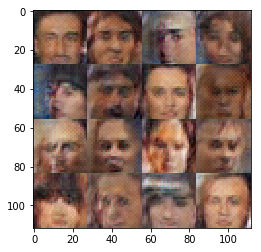

Epoch_i 0   batch count 7500/12662... Discriminator Loss: 1.5304... Generator Loss: 0.6702
Epoch_i 0   batch count 7650/12662... Discriminator Loss: 1.4480... Generator Loss: 0.6926
Epoch_i 0   batch count 7800/12662... Discriminator Loss: 1.4850... Generator Loss: 0.6555
Epoch_i 0   batch count 7950/12662... Discriminator Loss: 1.5246... Generator Loss: 0.6520


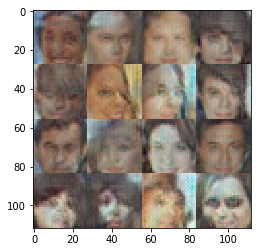

Epoch_i 0   batch count 8100/12662... Discriminator Loss: 1.4611... Generator Loss: 0.6332
Epoch_i 0   batch count 8250/12662... Discriminator Loss: 1.5223... Generator Loss: 0.6942
Epoch_i 0   batch count 8400/12662... Discriminator Loss: 1.5595... Generator Loss: 0.6130


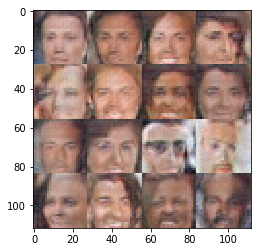

Epoch_i 0   batch count 8550/12662... Discriminator Loss: 1.5294... Generator Loss: 0.6382
Epoch_i 0   batch count 8700/12662... Discriminator Loss: 1.4282... Generator Loss: 0.6933
Epoch_i 0   batch count 8850/12662... Discriminator Loss: 1.5345... Generator Loss: 0.5601


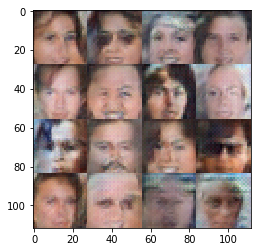

Epoch_i 0   batch count 9000/12662... Discriminator Loss: 1.4968... Generator Loss: 0.6405
Epoch_i 0   batch count 9150/12662... Discriminator Loss: 1.4646... Generator Loss: 0.7239
Epoch_i 0   batch count 9300/12662... Discriminator Loss: 1.6464... Generator Loss: 0.5383
Epoch_i 0   batch count 9450/12662... Discriminator Loss: 1.5732... Generator Loss: 0.5333


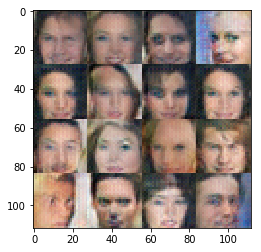

Epoch_i 0   batch count 9600/12662... Discriminator Loss: 1.6449... Generator Loss: 0.5491
Epoch_i 0   batch count 9750/12662... Discriminator Loss: 1.6349... Generator Loss: 0.5277
Epoch_i 0   batch count 11700/12662... Discriminator Loss: 1.6288... Generator Loss: 0.4861
Epoch_i 0   batch count 11850/12662... Discriminator Loss: 1.5083... Generator Loss: 0.5328


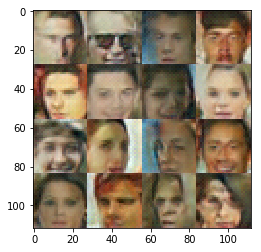

Epoch_i 0   batch count 12000/12662... Discriminator Loss: 1.5200... Generator Loss: 0.5600
Epoch_i 0   batch count 12150/12662... Discriminator Loss: 1.4931... Generator Loss: 0.5461
Epoch_i 0   batch count 12300/12662... Discriminator Loss: 1.4553... Generator Loss: 0.5572
Epoch_i 0   batch count 12450/12662... Discriminator Loss: 1.6962... Generator Loss: 0.4367


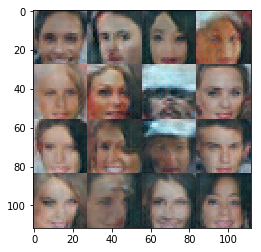

Epoch_i 0   batch count 12600/12662... Discriminator Loss: 1.7024... Generator Loss: 0.4303


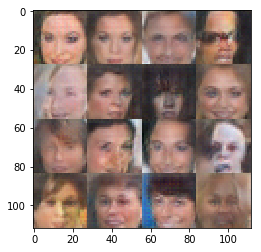

Epoch_i 0   batch count 12662/12662... Discriminator Loss: 1.6160... Generator Loss: 0.5576


In [ ]:
batch_size = 16
z_dim = 100
learning_rate = 0.002
beta1 = 0.5

tf.reset_default_graph()
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.